# Triangle Load on a Console

In [92]:
import numpy as np
from numpy import pi as PI

L, w, h = 1000.0, 20.0, 80.0  # geometry
Ex, nu = 210000.0, 0.25  # material

Iy = h * w**3 / 12
Iz = w * h**3 / 12
Ix = (Iy + Iz) / 2
A = w * h
EI = Ex * Iz
G = Ex / (2 * (1 + nu))
GA = G * A * 5 / 6

qy_max = 1.0  # max intensity of the load

$$
\begin{align*}

q_y(x) &= x \frac{q_{y,max}}{L}

\end{align*}
$$

In [93]:
def qy(x):
    return x * qy_max / L

## Finite Element Solution

In [94]:
from neumann.linalg import linspace
from neumann import repeat
from polymesh.space import StandardFrame
from polymesh.utils.space import index_of_closest_point, index_of_furthest_point
from polymesh.utils.topology import L2_to_L3
from sigmaepsilon.fem.cells.bernoulli import BernoulliBase
from sigmaepsilon.fem.cells import B2, B3
from sigmaepsilon import Structure, LineMesh, PointData
from typing import Callable

# material
G = Ex / (2 * (1 + nu))
Hooke = np.array(
    [[Ex * A, 0, 0, 0], [0, G * Ix, 0, 0], [0, 0, Ex * Iy, 0], [0, 0, 0, Ex * Iz]]
)


def solve(n: int, fnc: Callable, celltype: BernoulliBase = B2, 
          insert:bool=True, eps:float=1e-2):
    global i_middle

    # space
    GlobalFrame = StandardFrame(dim=3)

    # mesh
    if insert:
        p0 = np.array([eps, 0.0, 0.0])
        p1 = np.array([L, 0.0, 0.0])
        coords = linspace(p0, p1, n + 1)
        coords = np.vstack([[0., 0., 0.], coords])
        n += 1
    else:
        p0 = np.array([0.0, 0.0, 0.0])
        p1 = np.array([L, 0.0, 0.0])
        coords = linspace(p0, p1, n + 1)
    topo = np.zeros((n, 2), dtype=int)
    topo[:, 0] = np.arange(n)
    topo[:, 1] = np.arange(n) + 1
    if celltype.NNODE == 3:
        coords, topo = L2_to_L3(coords, topo)

    # mark some points
    i_first = index_of_closest_point(coords, np.array([0.0, 0.0, 0.0]))
    
    # essential boundary conditions
    penalty = 1e40  # penalty value for essential BCs
    fixity = np.zeros((coords.shape[0], 6)).astype(bool)
    fixity[i_first, :] = True
    fixity = fixity.astype(float) * penalty

    # natural boundary conditions
    nodal_loads = np.zeros((coords.shape[0], 6))
    cell_loads = np.zeros((topo.shape[0], topo.shape[1], 6))

    # pointdata
    pd = PointData(coords=coords, frame=GlobalFrame, loads=nodal_loads, fixity=fixity)

    # celldata
    frames = repeat(np.eye(3), topo.shape[0])
    cd = celltype(topo=topo, material=Hooke, frames=frames)
    cell_loads[:, :, 1] = cd.pull(data=fnc(coords[:, 0]))[:, :, 0]
    cd.loads = cell_loads

    # set up mesh and structure
    mesh = LineMesh(pd, cd, frame=GlobalFrame)
    structure = Structure(mesh=mesh)

    structure.linear_static_analysis()

    return structure

In [95]:
structure = solve(2, qy, B3, True, 0.1)
x = structure.mesh.coords()[:, 0]
u = structure.nodal_dof_solution()
r = structure.reaction_forces()

rng = [0, 1]
points = np.linspace(rng[0], rng[1], 20)
ui = structure.mesh.cell_dof_solution(
    points=points, rng=rng, target="global", flatten=False
)

fi = structure.internal_forces(points=points, rng=rng)
k = structure.mesh.strains(points=points, rng=rng)
xi = structure.mesh.cells_coords(points=points, rng=rng)

## Semi-Analytic Solution

$$
\begin{align*}

\theta_z(x) &= \frac{\partial u_y}{\partial x} \\

\kappa_z(x) &= \frac{\partial \theta_z}{\partial x} \\

M_z(x) &= E I_z \kappa_z(x) \\

V_y(x) &= - \frac{\partial M_z}{\partial x} \\

\end{align*}
$$

In [96]:
import sympy as sy

x_ = sy.symbols('x')
expr_kappa = (qy_max * (2*L**2/3 + x_**3/3/L - x_*L) / 2) / Ex / Iz
expr_theta = sy.integrate(expr_kappa, x_)
expr_uy = sy.integrate(expr_theta, x_)


def mz(x):
    return qy_max * (2*L**2/3 + x**3/3/L - x*L) / 2

def vy(x):
    return qy_max * (L - x**2 / L) / 2

def kz(x):
    return mz(x) / Ex / Iz

def rotz(x):
    return [expr_theta.subs(x_, xi) for xi in x]

def uy(x):
    return [expr_uy.subs(x_, xi) for xi in x]

## Comparison

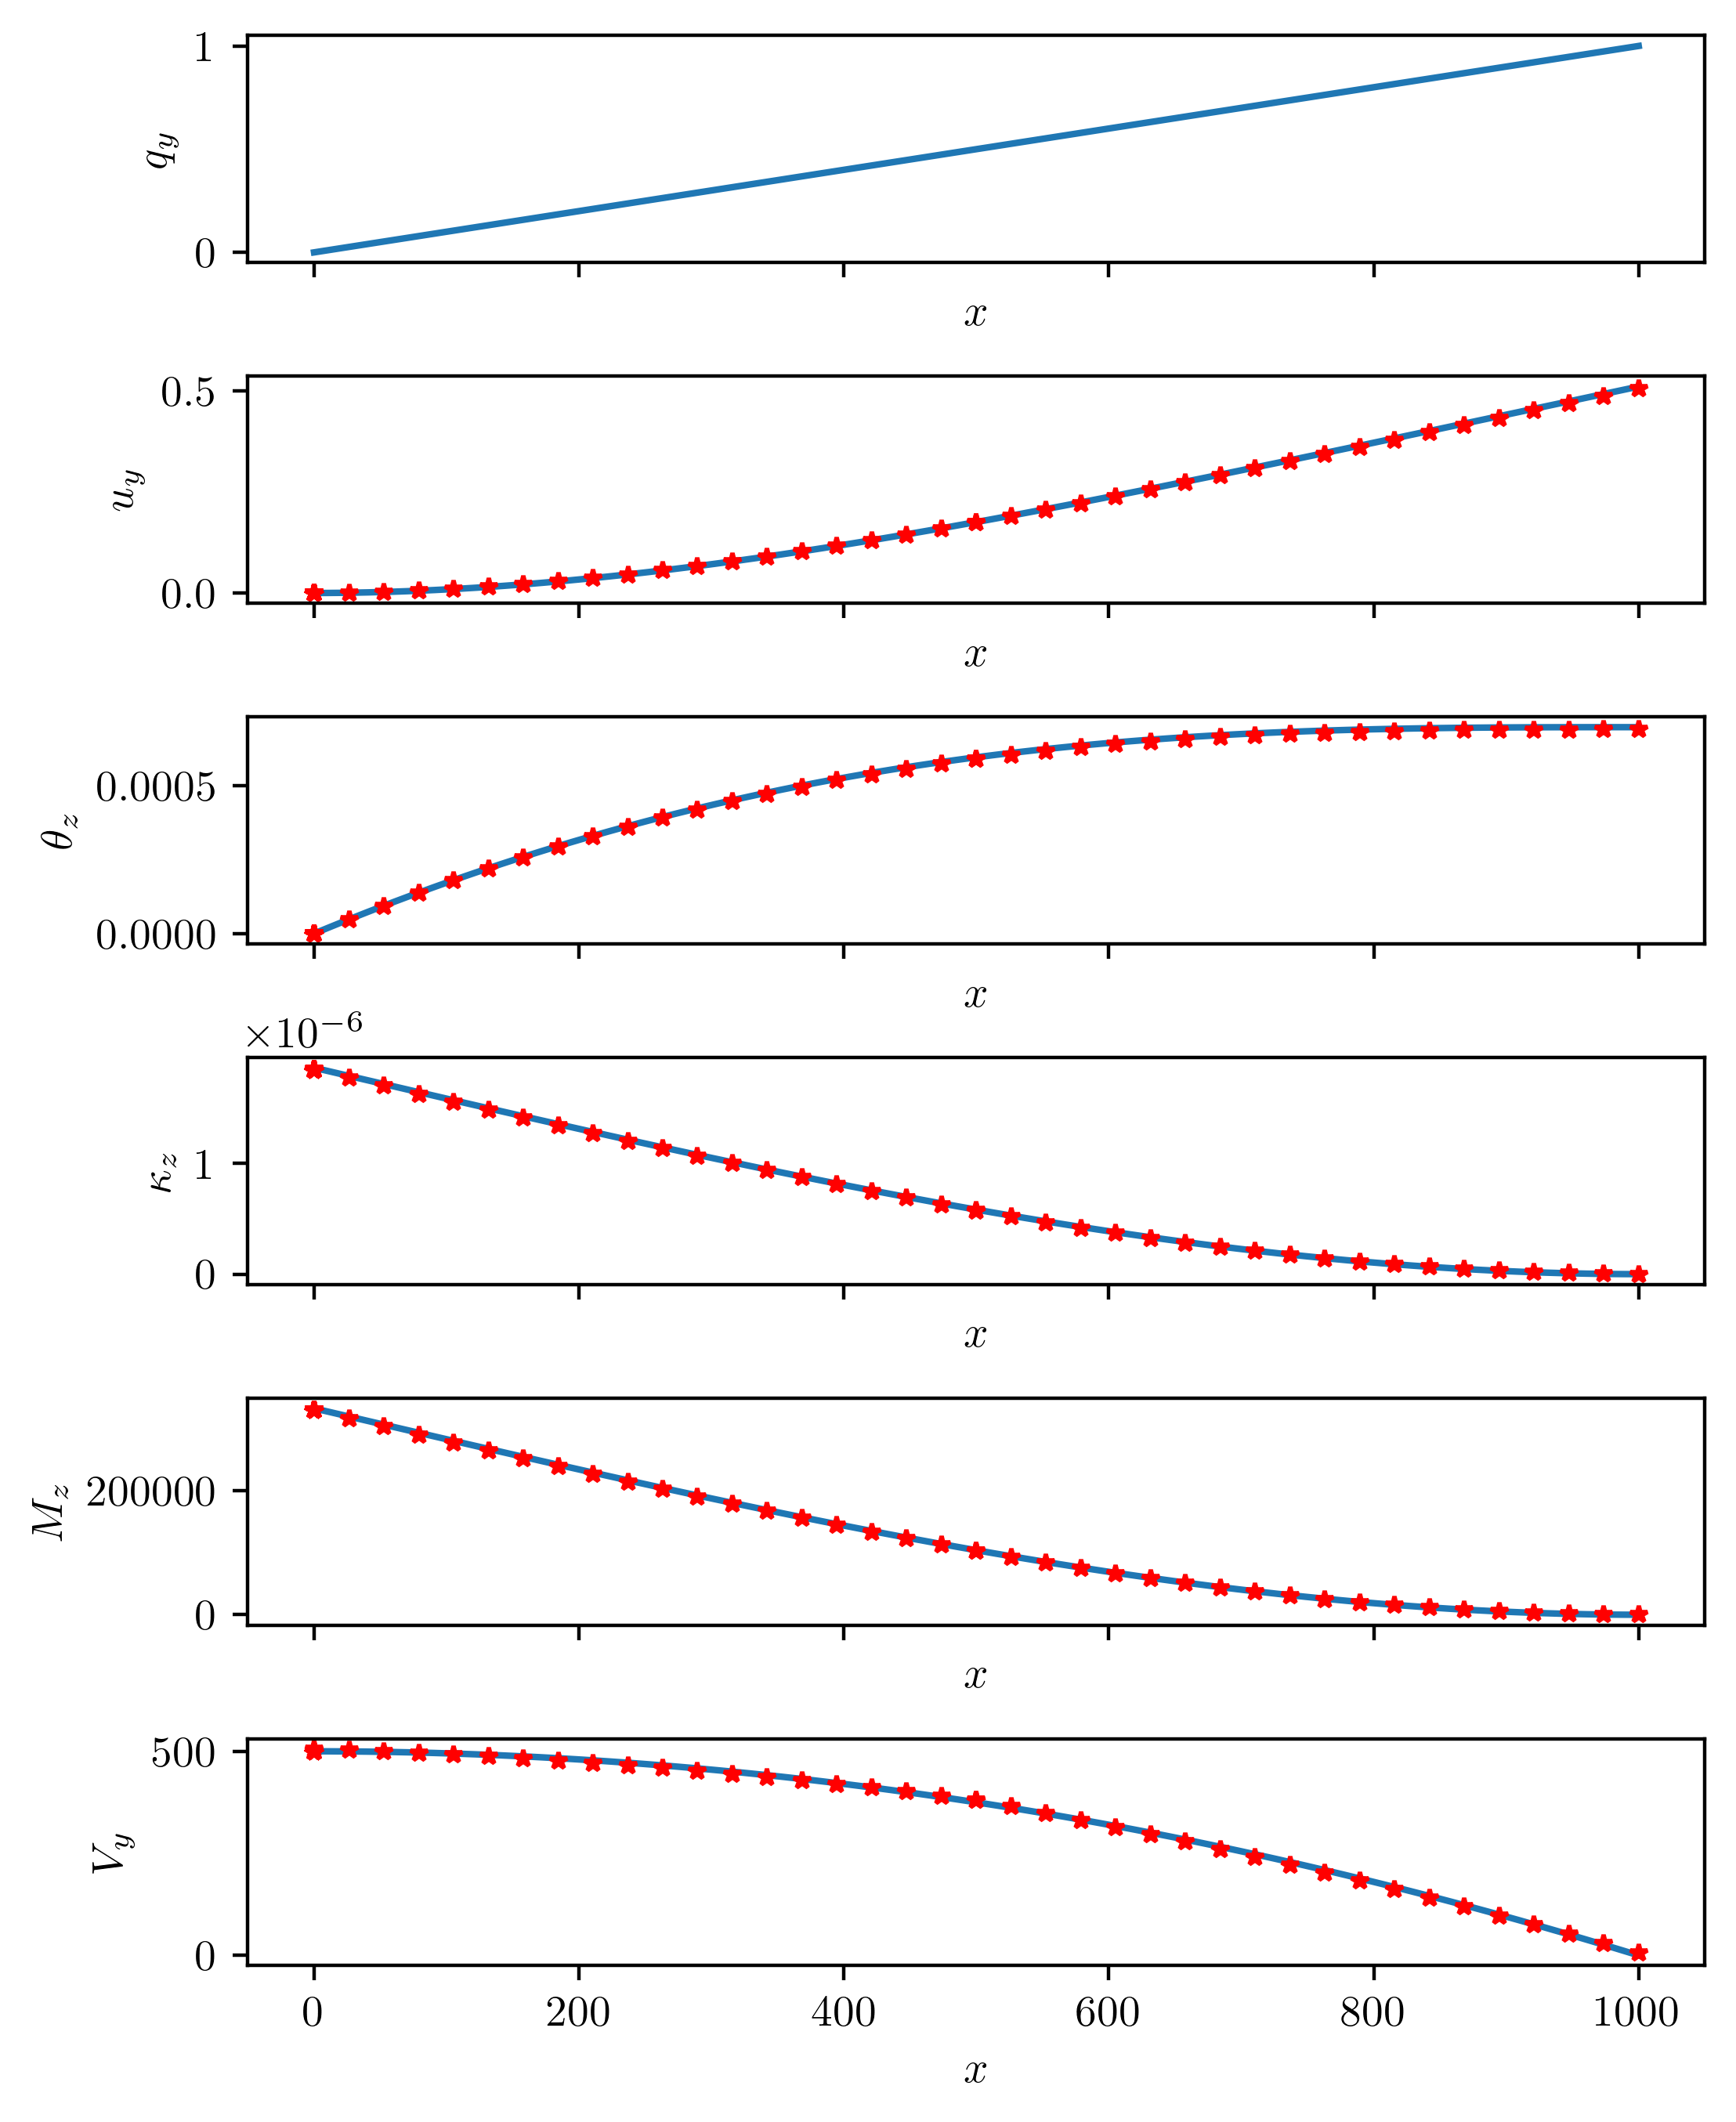

In [97]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 1, figsize=(6, 8), dpi=400, sharex=True)

_x = np.linspace(0, L, 100)
ms = 4

axs[0].plot(_x, qy(_x))
axs[0].set_xlabel("$x$")
axs[0].set_ylabel(r"$q_y$")

axs[1].plot(_x, uy(_x))
axs[1].plot(xi[:, :, 0].flatten(), ui[:, :, 1].flatten(), "r*", markersize=ms)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$u_y$")

axs[2].plot(_x, rotz(_x))
axs[2].plot(xi[:, :, 0].flatten(), ui[:, :, -1].flatten(), "r*", markersize=ms)
axs[2].set_xlabel("$x$")
axs[2].set_ylabel(r"$\theta_z$")

axs[3].plot(_x, kz(_x))
axs[3].plot(xi[:, :, 0].flatten(), k[:, :, -1].flatten(), "r*", markersize=ms)
axs[3].set_xlabel("$x$")
axs[3].set_ylabel("$\kappa_z$")

axs[4].plot(_x, mz(_x))
axs[4].plot(xi[:, :, 0].flatten(), fi[:, :, -1].flatten(), "r*", markersize=ms)
axs[4].set_xlabel("$x$")
axs[4].set_ylabel("$M_z$")

axs[5].plot(_x, vy(_x))
axs[5].plot(xi[:, :, 0].flatten(), fi[:, :, 1].flatten(), "r*", markersize=ms)
axs[5].set_xlabel("$x$")
axs[5].set_ylabel("$V_y$")

plt.subplots_adjust(hspace=0.5)

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
    }
)